In [2]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [3]:
##cell##
import numpy as np

def load_profits_from_file(filename, num_objectives, num_items):
    profits = np.zeros((num_objectives, num_items))
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            idx += 1  # skip weight
            profit = int(lines[idx])
            profits[obj, item] = profit
            idx += 1
    return profits

def load_weights_from_file(filename, num_objectives, num_items):
    weights = np.zeros((num_objectives, num_items), dtype=int)
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            weight = int(lines[idx])
            weights[obj, item] = weight
            idx += 2  # skip profit
    return weights

def load_capacities_from_file(filename, num_objectives, num_items):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    capacities = []
    for obj in range(num_objectives):
        cap = float(lines[idx])
        capacities.append(cap)
        idx += 1 + 3 * num_items
    return np.array(capacities)


In [4]:
##cell##
import numpy as np
import random
import copy

# --- Move Sub-Function Registry ---
def mutation_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    items_selected = np.where(observation == 1)[0]
    items_unselected = np.where(observation == 0)[0]
    if len(items_selected) == 0 or len(items_unselected) == 0:
        return 0, 0
    remove_idx = int(np.random.choice(items_selected))
    add_idx = int(np.random.choice(items_unselected))
    return remove_idx, add_idx

def local_search_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    items_selected = np.where(observation == 1)[0]
    items_unselected = np.where(observation == 0)[0]
    if len(items_selected) == 0 or len(items_unselected) == 0 or profits is None:
        return 0, 0
    profs_selected = np.sum(profits[:, items_selected], axis=0)
    profs_unselected = np.sum(profits[:, items_unselected], axis=0)
    remove_idx = items_selected[np.argmin(profs_selected)]
    add_idx = items_unselected[np.argmax(profs_unselected)]
    return int(remove_idx), int(add_idx)

def global_search_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    items_selected = np.where(observation == 1)[0]
    items_unselected = np.where(observation == 0)[0]
    if len(items_selected) == 0 or len(items_unselected) == 0 or profits is None:
        return 0, 0
    profs_selected = np.sum(profits[:, items_selected], axis=0)
    profs_unselected = np.sum(profits[:, items_unselected], axis=0)
    ps = profs_selected + 1e-9
    pu = profs_unselected + 1e-9
    remove_idx = np.random.choice(items_selected, p=ps / np.sum(ps))
    add_idx = np.random.choice(items_unselected, p=pu / np.sum(pu))
    return int(remove_idx), int(add_idx)

def follow_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    if best_observation is None:
        return mutation_move(observation, profits, weights, capacities)
    diff = best_observation - observation
    add_candidates = np.where((diff == 1) & (observation == 0))[0]
    remove_candidates = np.where((diff == -1) & (observation == 1))[0]
    if len(add_candidates) == 0 or len(remove_candidates) == 0:
        return mutation_move(observation, profits, weights, capacities)
    add_idx = np.random.choice(add_candidates)
    remove_idx = np.random.choice(remove_candidates)
    return int(remove_idx), int(add_idx)

def diversity_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    best_move = None
    best_min_dist = -np.inf
    items_selected = np.where(observation == 1)[0]
    items_unselected = np.where(observation == 0)[0]
    if len(items_selected) == 0 or len(items_unselected) == 0 or archive_objs is None:
        return 0, 0
    for _ in range(3):
        remove_idx = int(np.random.choice(items_selected))
        add_idx = int(np.random.choice(items_unselected))
        candidate = observation.copy()
        candidate[remove_idx] = 0
        candidate[add_idx] = 1
        candidate_objs = np.sum(profits * candidate, axis=1)
        dists = np.linalg.norm(archive_objs - candidate_objs, axis=1)
        min_dist = np.min(dists)
        if min_dist > best_min_dist:
            best_min_dist = min_dist
            best_move = (remove_idx, add_idx)
    return best_move if best_move is not None else (0, 0)

# Registry for moves (for easy mutation/add/remove)
MOVE_REGISTRY = {
    "mutation": mutation_move,
    "local_search": local_search_move,
    "global_search": global_search_move,
    "follow": follow_move,
    "diversity": diversity_move,
}

# --- Modular Agent Architecture ---
class AgentArchitecture:
    """
    Defines how an agent selects a move sub-function.
    For now, softmax over historical success. Can be replaced by other strategies.
    """
    def __init__(self, move_types, smoothing=0.1):
        self.move_types = list(move_types)
        self.move_counts = {k: 1 for k in self.move_types}
        self.move_successes = {k: 1 for k in self.move_types}
        self.move_probs = np.ones(len(self.move_types)) / len(self.move_types)
        self.smoothing = smoothing

    def select_move(self):
        idx = np.random.choice(len(self.move_types), p=self.move_probs)
        move_type = self.move_types[idx]
        return move_type

    def report_move_result(self, move_type, success):
        if move_type not in self.move_types:
            return
        self.move_counts[move_type] += 1
        if success:
            self.move_successes[move_type] += 1
        # Softmax move adaptation
        rates = np.array([self.move_successes[k]/self.move_counts[k] for k in self.move_types], dtype=np.float64)
        exp_rates = np.exp(rates / self.smoothing)
        new_probs = exp_rates / np.sum(exp_rates)
        self.move_probs = 0.5 * self.move_probs + 0.5 * new_probs
        self.move_probs = self.move_probs / np.sum(self.move_probs)

    def clone(self):
        arch = AgentArchitecture(self.move_types, self.smoothing)
        arch.move_counts = dict(self.move_counts)
        arch.move_successes = dict(self.move_successes)
        arch.move_probs = np.copy(self.move_probs)
        return arch

    def mutate(self, registry, mutation_rate=0.25):
        # Randomly drop, add, or swap move types
        move_types = set(self.move_types)
        all_types = set(registry.keys())
        # Randomly add a new move
        if random.random() < mutation_rate and len(move_types) < len(all_types):
            add = random.choice(list(all_types - move_types))
            move_types.add(add)
        # Randomly drop a move
        if random.random() < mutation_rate and len(move_types) > 1:
            drop = random.choice(list(move_types))
            move_types.remove(drop)
        # Optionally shuffle move_types order
        move_types = list(move_types)
        random.shuffle(move_types)
        self.move_types = move_types
        # Reset adaptation data for new/removed moves
        self.move_counts = {k: 1 for k in self.move_types}
        self.move_successes = {k: 1 for k in self.move_types}
        self.move_probs = np.ones(len(self.move_types)) / len(self.move_types)

# --- Modular Agent ---
class ModularMetaAgent:
    def __init__(self, num_items, num_objectives, profits, weights, capacities, move_types=None, smoothing=0.1):
        self.num_items = num_items
        self.num_objectives = num_objectives
        self.profits = profits
        self.weights = weights
        self.capacities = capacities
        self.architecture = AgentArchitecture(move_types if move_types else list(MOVE_REGISTRY.keys()), smoothing=smoothing)
        self.best_observation = None
        self.last_move_type = None

    def observe(self, state):
        return np.array(state["Items"], dtype=np.int32)

    def act(self, observation, context=None):
        archive_objs = context.get("archive_objs") if context else None
        best_obs = self.best_observation
        for _ in range(3):
            move_type = self.architecture.select_move()
            move_fn = MOVE_REGISTRY[move_type]
            move = move_fn(
                observation, self.profits, self.weights, self.capacities,
                archive_objs=archive_objs, best_observation=best_obs
            )
            if self._is_feasible(observation, move):
                self.last_move_type = move_type
                return move
        # fallback
        move = mutation_move(observation, self.profits, self.weights, self.capacities)
        self.last_move_type = "mutation"
        return move

    def report_move_result(self, move_type, success):
        if move_type is None:
            move_type = self.last_move_type
        self.architecture.report_move_result(move_type, success)

    def update_best(self, observation):
        self.best_observation = observation.copy()

    def _is_feasible(self, observation, move):
        if self.weights is None or self.capacities is None or move is None:
            return True
        remove_idx, add_idx = move
        if remove_idx == add_idx:
            return False
        items = observation.copy()
        if items[remove_idx] == 0 or items[add_idx] == 1:
            return False
        items[remove_idx] = 0
        items[add_idx] = 1
        total_weights = np.sum(self.weights * items, axis=1)
        feasible = np.all(total_weights <= self.capacities)
        return feasible

    def clone(self):
        agent = ModularMetaAgent(
            self.num_items, self.num_objectives, self.profits, self.weights, self.capacities
        )
        agent.architecture = self.architecture.clone()
        if self.best_observation is not None:
            agent.best_observation = self.best_observation.copy()
        return agent

    def mutate(self, registry, mutation_rate=0.25):
        self.architecture.mutate(registry, mutation_rate=mutation_rate)

# --- Population Manager with Agent Structure Evolution ---
class ModularAgentPopulationManager:
    def __init__(self, num_agents, num_items, num_objectives, profits, weights, capacities):
        self.num_agents = num_agents
        self.registry = MOVE_REGISTRY
        self.agents = [
            ModularMetaAgent(
                num_items, num_objectives, profits, weights, capacities,
                move_types=random.sample(list(MOVE_REGISTRY.keys()), k=random.randint(2, len(MOVE_REGISTRY)))
            )
            for _ in range(num_agents)
        ]
        self.agent_stats = [ {"fitness_sum": 0.0, "moves": 0} for _ in range(num_agents) ]

    def select_agent_for_solution(self, solution_idx):
        return self.agents[solution_idx % self.num_agents]

    def report_agent_performance(self, agent_idx, solution_fitness):
        self.agent_stats[agent_idx]["fitness_sum"] += solution_fitness
        self.agent_stats[agent_idx]["moves"] += 1

    def gses_agent_level(self):
        avg_fitness = [s["fitness_sum"]/s["moves"] if s["moves"] > 0 else -1e9 for s in self.agent_stats]
        sorted_idx = np.argsort(-np.array(avg_fitness))
        survivors = [self.agents[i] for i in sorted_idx[:max(2, self.num_agents//2)]]
        # Crossover: randomly pair and combine move sets
        new_agents = []
        while len(new_agents) + len(survivors) < self.num_agents:
            parent1, parent2 = random.sample(survivors, 2)
            child = parent1.clone()
            # Crossover move types
            moves1 = set(parent1.architecture.move_types)
            moves2 = set(parent2.architecture.move_types)
            moves_child = list(moves1 | moves2)
            # Randomly drop some moves to maintain diversity
            if len(moves_child) > 2:
                moves_child = random.sample(moves_child, k=random.randint(2, len(moves_child)))
            child.architecture.move_types = moves_child
            child.architecture.move_counts = {k: 1 for k in moves_child}
            child.architecture.move_successes = {k: 1 for k in moves_child}
            child.architecture.move_probs = np.ones(len(moves_child)) / len(moves_child)
            # Mutate agent structure/parameters
            child.mutate(self.registry, mutation_rate=0.25)
            new_agents.append(child)
        self.agents = survivors + new_agents
        self.agent_stats = [ {"fitness_sum": 0.0, "moves": 0} for _ in range(self.num_agents) ]

In [5]:
%%cython
from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp
import numpy as np
cimport numpy as np
import time

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

cdef int NBITEMS = 250
cdef int ni = 250
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000

cdef int nf = 2
cdef double *capacities = NULL
cdef int **weights = NULL
cdef int **profits = NULL
cdef double *vector_weight = NULL
cdef double max_bound = 0.0
cdef double **OBJ_Weights = NULL
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0
cdef int OBJ_Weights_lines = 0

cdef public object py_agent_manager = None
cdef public object move_stats = None

def set_agent_manager(agent_manager):
    global py_agent_manager
    py_agent_manager = agent_manager

def reset_move_stats():
    global move_stats
    move_stats = {"total_agent_calls": 0, "move_type_counts": {}, "total_time_agent": 0.0, "total_time_loop": 0.0}

def print_move_stats():
    print("\n=== AGENT MOVE PROFILE ===")
    print("Total agent calls:", move_stats["total_agent_calls"])
    print("Move type counts:", move_stats["move_type_counts"])
    print("Total agent time (sec):", move_stats["total_time_agent"])
    print("Total loop time (sec):", move_stats["total_time_loop"])
    if move_stats["total_agent_calls"] > 0:
        print("Avg agent call time (ms):", 1000.0 * move_stats["total_time_agent"] / move_stats["total_agent_calls"])

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

cdef void cleanup_globals():
    global capacities, weights, profits, vector_weight, OBJ_Weights, OBJ_Weights_lines, nf, ni
    if capacities != NULL:
        free(capacities)
        capacities = NULL
    if weights != NULL:
        for i in range(nf):
            if weights[i] != NULL:
                free(weights[i])
        free(weights)
        weights = NULL
    if profits != NULL:
        for i in range(nf):
            if profits[i] != NULL:
                free(profits[i])
        free(profits)
        profits = NULL
    if vector_weight != NULL:
        free(vector_weight)
        vector_weight = NULL
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    OBJ_Weights_lines = 0
    nf = 0
    ni = 0

cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i
    cdef int a_is_good = -1
    cdef int equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps
    cdef double temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i, f
    with open(filename.decode(), "r") as source:
        _nf, _ni = [int(x) for x in source.readline().split()]
        nf = _nf
        ni = _ni
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            weights[f] = <int *>chk_malloc(ni * sizeof(int))
            profits[f] = <int *>chk_malloc(ni * sizeof(int))
            for i in range(ni):
                source.readline()
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf, OBJ_Weights_lines
    cdef int i, j, nlines
    with open(filename.decode(), "r") as f:
        lines = [line for line in f if line.strip()]
    nlines = len(lines)
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(nlines * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = nlines - 1
    OBJ_Weights_lines = nlines

cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

cdef void random_init_ind(ind *x):
    cdef int j, r, tmp
    for j in range(ni):
        x.d[j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j, l, k, faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i, x, tmp, t
    t = max(alpha, Sarchive.size)
    cdef int* shuffle = <int *>chk_malloc(t * sizeof(int))
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])
    free(shuffle)

cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i, j, dom, t, convergence_rate
    t = archive.size + P.size
    archiveAndP = create_pop(t, nf)
    convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i, j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i, j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i, worst
    cdef double worst_fit, fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    worst = -1
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x.fitness
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

cdef np.ndarray get_archive_objs(pop *archive):
    cdef int i, j
    arr = np.zeros((archive.size, nf), dtype=np.float64)
    for i in range(archive.size):
        for j in range(nf):
            arr[i, j] = archive.ind_array[i].f[j]
    return arr

cdef np.ndarray get_items(ind *x):
    arr = np.zeros(ni, dtype=np.int32)
    cdef int i
    for i in range(ni):
        arr[i] = x.Items[i]
    return arr

# --- Built-in Cython move functions ---
cdef tuple cy_mutation_move(np.ndarray[np.int32_t, ndim=1] items, int ni):
    cdef int n_selected = 0, n_unselected = 0, i
    for i in range(ni):
        if items[i] == 1: n_selected += 1
        else: n_unselected += 1
    if n_selected == 0 or n_unselected == 0:
        return (0, 0)
    sel = [i for i in range(ni) if items[i] == 1]
    unsel = [i for i in range(ni) if items[i] == 0]
    remove_idx = sel[irand(n_selected)]
    add_idx = unsel[irand(n_unselected)]
    return remove_idx, add_idx

cdef tuple cy_local_search_move(np.ndarray[np.int32_t, ndim=1] items, double[:, :] profits, int ni, int nf):
    cdef int i
    sel = [i for i in range(ni) if items[i] == 1]
    unsel = [i for i in range(ni) if items[i] == 0]
    if not sel or not unsel:
        return (0, 0)
    profs_selected = [sum([profits[f, idx] for f in range(nf)]) for idx in sel]
    profs_unselected = [sum([profits[f, idx] for f in range(nf)]) for idx in unsel]
    remove_idx = sel[np.argmin(profs_selected)]
    add_idx = unsel[np.argmax(profs_unselected)]
    return remove_idx, add_idx

cdef tuple cy_global_search_move(np.ndarray[np.int32_t, ndim=1] items, double[:, :] profits, int ni, int nf):
    cdef int i
    sel = [i for i in range(ni) if items[i] == 1]
    unsel = [i for i in range(ni) if items[i] == 0]
    if not sel or not unsel:
        return (0, 0)
    profs_selected = np.array([sum([profits[f, idx] for f in range(nf)]) for idx in sel], dtype=np.float64) + 1e-9
    profs_unselected = np.array([sum([profits[f, idx] for f in range(nf)]) for idx in unsel], dtype=np.float64) + 1e-9
    remove_idx = sel[np.random.choice(len(sel), p=profs_selected/np.sum(profs_selected))]
    add_idx = unsel[np.random.choice(len(unsel), p=profs_unselected/np.sum(profs_unselected))]
    return remove_idx, add_idx

def get_profits_np():
    global profits, nf, ni
    arr = np.zeros((nf, ni), dtype=np.float64)
    for f in range(nf):
        for i in range(ni):
            arr[f, i] = profits[f][i]
    return arr

cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef ind *y
    cdef int i, j, r, t, k, l, v, sol, mino, mp, maxp, consistant, pos, stop, convergence, ii, tmp_pris, tmp_nonpris, taille, feasible, tv, IM
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    cdef np.ndarray[np.int32_t, ndim=1] items_mv = np.empty(ni, dtype=np.int32)
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    profits_np = get_profits_np()
    while True:
        convergence = 0
        archive_objs = get_archive_objs(Sarchive) if Sarchive.size > 0 else None
        loop_start_time = time.time()
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    for ii in range(ni):
                        items_mv[ii] = x.Items[ii]
                    # --------- SELECT MOVE TYPE & EXECUTE ---------
                    move_types = ["mutation", "local_search", "global_search", "follow", "diversity"]
                    mt_idx = irand(5)
                    move_type = move_types[mt_idx]
                    remove_idx = -1
                    add_idx = -1
                    agent_move_type = move_type
                    agent_success = False
                    agent_start_time = time.time()
                    # Built-in moves:
                    if move_type == "mutation":
                        remove_idx, add_idx = cy_mutation_move(items_mv, ni)
                    elif move_type == "local_search":
                        remove_idx, add_idx = cy_local_search_move(items_mv, profits_np, ni, nf)
                    elif move_type == "global_search":
                        remove_idx, add_idx = cy_global_search_move(items_mv, profits_np, ni, nf)
                    # Agent moves:
                    elif (move_type == "diversity" or move_type == "follow") and py_agent_manager is not None:
                        agent_idx = i % py_agent_manager.num_agents
                        agent = py_agent_manager.agents[agent_idx]
                        state = {
                            "Items": [x.Items[ii] for ii in range(ni)],
                            "capa": [x.capa[ii] for ii in range(nf)],
                            "f": [x.f[ii] for ii in range(nf)],
                        }
                        context = {}
                        if archive_objs is not None:
                            context["archive_objs"] = archive_objs
                        try:
                            obs = agent.observe(state)
                            remove_idx, add_idx = agent.act(obs, context)
                            if hasattr(agent, "last_move_type"):
                                agent_move_type = agent.last_move_type
                        except Exception as e:
                            print("Agent error:", e)
                            remove_idx = -1
                            add_idx = -1
                            agent_move_type = "error"
                    agent_end_time = time.time()
                    if move_stats is not None:
                        move_stats["total_agent_calls"] += 1
                        move_stats["total_time_agent"] += (agent_end_time - agent_start_time)
                        mt = agent_move_type if agent_move_type is not None else "unknown"
                        if mt not in move_stats["move_type_counts"]:
                            move_stats["move_type_counts"][mt] = 0
                        move_stats["move_type_counts"][mt] += 1
                    # Fallback logic:
                    if remove_idx < 0 or remove_idx >= ni or x.Items[remove_idx] != 1:
                        while True:
                            mino = irand(ni)
                            if x.Items[mino] == 1:
                                break
                        remove_idx = mino
                    if add_idx < 0 or add_idx >= ni or x.Items[add_idx] != 0 or add_idx == remove_idx:
                        while True:
                            maxp = irand(ni)
                            if x.Items[maxp] == 0 and maxp != remove_idx:
                                break
                        add_idx = maxp
                    # Remove item
                    x.Items[remove_idx] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][remove_idx]
                        x.f[r] -= profits[r][remove_idx]
                    IM = 0
                    taille = 0
                    while IM < L:
                        item_to_add = add_idx
                        if item_to_add < 0 or item_to_add >= ni or x.Items[item_to_add] != 0 or item_to_add == remove_idx:
                            while True:
                                item_to_add = irand(ni)
                                if x.Items[item_to_add] == 0 and item_to_add != remove_idx:
                                    break
                        consistant = 1
                        r = 0
                        while r < nf and consistant == 1:
                            if x.capa[r] + weights[r][item_to_add] > capacities[r]:
                                consistant = 0
                            r += 1
                        if consistant == 1:
                            feasible = 1
                            r = 0
                            while r < taille and feasible:
                                if item_to_add == remplace[r]:
                                    feasible = 0
                                r += 1
                            if feasible == 1:
                                remplace[taille] = item_to_add
                                taille += 1
                                x.Items[item_to_add] = 1
                                x.nombr_nonpris -= 1
                                x.nombr += 1
                                for r in range(nf):
                                    x.capa[r] += weights[r][item_to_add]
                                    x.f[r] += profits[r][item_to_add]
                        IM += 1
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * vector_weight[tv]
                    max_bound = calcMaxbound(SP, SP.size)
                    sol = compute_fitness_and_select(SP, x, SP.size)
                    agent_success = (sol != -1)
                    if py_agent_manager is not None and (move_type == "diversity" or move_type == "follow"):
                        try:
                            agent.report_move_result(agent_move_type, agent_success)
                        except Exception:
                            pass
                    if py_agent_manager is not None:
                        agent_idx = i % py_agent_manager.num_agents
                        fitness = np.sum([x.f[j] for j in range(nf)])
                        py_agent_manager.report_agent_performance(agent_idx, fitness)
                    if sol != -1:
                        j = x.nombr + 1
                        if sol > i and i + 1 < SP.size:
                            y = SP.ind_array[i + 1]
                            SP.ind_array[i + 1] = SP.ind_array[sol]
                            SP.ind_array[sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x.Items[remove_idx] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r in range(nf):
                            x.capa[r] += weights[r][remove_idx]
                            x.f[r] += profits[r][remove_idx]
                        if taille >= 1:
                            for r in range(taille):
                                x.Items[remplace[r]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(nf):
                                    x.capa[t] -= weights[t][remplace[r]]
                                    x.f[t] -= profits[t][remplace[r]]
                                    x.v[t] = x.f[t] * vector_weight[t]
                    j += 1
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                if j == tmp_pris:
                    SP.ind_array[i].explored = 1
        loop_end_time = time.time()
        if move_stats is not None:
            move_stats["total_time_loop"] += (loop_end_time - loop_start_time)
        convergence = extractPtoArchive(SP, Sarchive)
        if not convergence:
            break
    free(remplace)

def run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file):
    global nf, ni, NBITEMS, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights

    alpha = 10
    paretoIni = 28000

    NBL = 25
    NRUNS = 3

    reset_move_stats()    # Only once, before runs

    for run in range(1, NRUNS+1):
        NBITEMS = nbitems
        ni = nbitems
        nf = num_objectives

        print(f"RUN {run}/{NRUNS} -- {instance_file.decode()} nbitems={ni} nf={nf} => {output_file}")

        nombreLIGNE = 0
        nextLn = 0
        inv = 0

        seed(run)
        loadMOKP(instance_file)
        read_weights_file(weights_file)

        vector_weight = <double *>chk_malloc(nf * sizeof(double))
        P = create_pop(paretoIni, nf)

        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)
            Indicator_local_search1(solutions, archive, alpha)
            extractPtoArchive(archive, P)
            # Agent population GSES every 10 iterations
            if py_agent_manager is not None and hasattr(py_agent_manager, "gses_agent_level") and it % 10 == 0:
                py_agent_manager.gses_agent_level()
            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)

        with open(output_file, "a") as fpareto:
            fpareto.write("\n")
            for i in range(P.size):
                for j in range(nf):
                    fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
                fpareto.write("\n")

        complete_free_pop(P)
        cleanup_globals()
        print_move_stats()


performance hint: C:\Users\Aziz il patal\.ipython\cython\_cython_magic_16ae32909fe16c9ad870b5cbf5bb797a9d17216ef3dc2db6830fdb0a3342a222.pyx:450:38: Index should be typed for more efficient access
performance hint: C:\Users\Aziz il patal\.ipython\cython\_cython_magic_16ae32909fe16c9ad870b5cbf5bb797a9d17216ef3dc2db6830fdb0a3342a222.pyx:451:40: Index should be typed for more efficient access
performance hint: C:\Users\Aziz il patal\.ipython\cython\_cython_magic_16ae32909fe16c9ad870b5cbf5bb797a9d17216ef3dc2db6830fdb0a3342a222.pyx:462:47: Index should be typed for more efficient access
performance hint: C:\Users\Aziz il patal\.ipython\cython\_cython_magic_16ae32909fe16c9ad870b5cbf5bb797a9d17216ef3dc2db6830fdb0a3342a222.pyx:463:49: Index should be typed for more efficient access


Content of stdout:
_cython_magic_16ae32909fe16c9ad870b5cbf5bb797a9d17216ef3dc2db6830fdb0a3342a222.c
A:\conda\envs\ibmols\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_16ae32909fe16c9ad870b5cbf5bb797a9d17216ef3dc2db6830fdb0a3342a222.c(21195): warning C4244: '='ÿ: conversion de 'double' en 'float', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_16ae32909fe16c9ad870b5cbf5bb797a9d17216ef3dc2db6830fdb0a3342a222.c(21285): warning C4244: '='ÿ: conversion de 'double' en 'float', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_16ae32909fe16c9ad870b5cbf5bb797a9d17216ef3dc2db6830fdb0a3342a222.c(22295): warning C4244: '='ÿ: conversion de 'Py_ssize_t' en 'int', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_16ae32909fe16

In [6]:
##cell##
import numpy as np

# --- Parameters and File Names ---
nbitems = 250
num_objectives = 2
instance_file = b"250.2.txt"
weights_file = b"Weights_2obj_FQ200.txt"
output_file = "plz.txt"
random_seed = 42
# 1. Load your instance as usual
profits = load_profits_from_file("250.2.txt", num_objectives, nbitems)
weights = load_weights_from_file("250.2.txt", num_objectives, nbitems)
capacities = load_capacities_from_file("250.2.txt", num_objectives, nbitems)

# 2. Create the modular MHRE agent population
agent_manager = ModularAgentPopulationManager(
    num_agents=10,  # or whatever population size you want
    num_items=nbitems,
    num_objectives=num_objectives,
    profits=profits,
    weights=weights,
    capacities=capacities
)

# 3. Register agent manager with cython
set_agent_manager(agent_manager)

# 4. Run the optimizer
run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file)
print("Optimization completed.")


RUN 1/3 -- 250.2.txt nbitems=250 nf=2 => plz.txt

=== AGENT MOVE PROFILE ===
Total agent calls: 97327
Move type counts: {'global_search': 21827, 'mutation': 51384, 'follow': 2264, 'local_search': 19642, 'diversity': 2210}
Total agent time (sec): 15.575379133224487
Total loop time (sec): 17.734809637069702
Avg agent call time (ms): 0.1600314314961366
RUN 2/3 -- 250.2.txt nbitems=250 nf=2 => plz.txt

=== AGENT MOVE PROFILE ===
Total agent calls: 194756
Move type counts: {'global_search': 43206, 'mutation': 104241, 'follow': 4283, 'local_search': 39229, 'diversity': 3797}
Total agent time (sec): 31.010490655899048
Total loop time (sec): 35.03061771392822
Avg agent call time (ms): 0.15922739559191526
RUN 3/3 -- 250.2.txt nbitems=250 nf=2 => plz.txt

=== AGENT MOVE PROFILE ===
Total agent calls: 243154
Move type counts: {'global_search': 54398, 'mutation': 128022, 'follow': 6608, 'local_search': 49370, 'diversity': 4756}
Total agent time (sec): 38.16779899597168
Total loop time (sec): 42.96

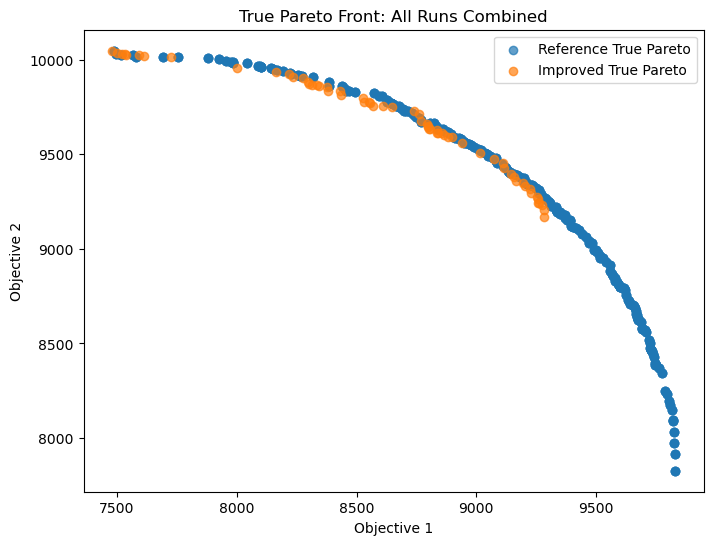

In [7]:
##cell##
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("plz.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

In [15]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
A:\conda\envs\ibmols\python.exe

In [37]:
import sys
print(sys.executable)

A:\conda\envs\ibmols\python.exe


In [5]:
import sklearn
print(sklearn.__file__)

A:\conda\envs\ibmols\lib\site-packages\sklearn\__init__.py


In [5]:
import numpy, scipy, sklearn
print(numpy.__version__, scipy.__version__, sklearn.__version__)

1.26.4 1.13.1 1.6.1


In [6]:
import requests
resp = requests.post("http://localhost:11434/api/generate", json={"model": "llama3", "prompt": "def f(): return 1", "stream": False})
print(resp.json())

{'model': 'llama3', 'created_at': '2025-09-06T17:51:18.9589415Z', 'response': "A nice simple one!\n\nThe function `f` is defined as:\n```\ndef f(): return 1\n```\nThis is a function that takes no arguments and returns the value `1`.\n\nYou can call this function like any other:\n```\nresult = f()\nprint(result)  # Output: 1\n```\nNote that there's no parameter list (`()`), which means the function doesn't take any arguments. The `return` statement specifies what value is returned when the function is called. In this case, it's always `1`.", 'done': True, 'done_reason': 'stop', 'context': [128006, 882, 128007, 271, 755, 282, 4658, 471, 220, 16, 128009, 128006, 78191, 128007, 271, 32, 6555, 4382, 832, 2268, 791, 734, 1595, 69, 63, 374, 4613, 439, 512, 14196, 4077, 755, 282, 4658, 471, 220, 16, 198, 14196, 4077, 2028, 374, 264, 734, 430, 5097, 912, 6105, 323, 4780, 279, 907, 1595, 16, 63438, 2675, 649, 1650, 420, 734, 1093, 904, 1023, 512, 14196, 4077, 1407, 284, 282, 746, 1374, 4556, 8, 